# Implementação 1: Toy Example

Esse notebook apresenta a primeira implementação do Toy Example proposto.
Sua proposta segue os seguintes objetivos:
* A implementação não seguirá padrões sugeridos nos campos das dimensões da IAR.
* Esse notebook servirá de checagem para análise da eficiência e corretude da checklist proposta pelo NIAR.

## Processamento dos dados

Os dados são de origem do Datasus, contendo informações das internações nos períodos de 2022 à novembro de 2025 (dados mais recentes quando feito esse Toy Example).

Devido ao tamanho dos dados brutos, não se encontram na página do Github. No entanto, a tabela final (após todo o pré processamento) se encontra em "Tabela_lag_final.zip". Apenas essa tabela é necessária para a execução do notebook. Para tal, descomprima o arquivo zip e coloque o arquivo "Tabela_lag_final.csv" (o único arquivo csv) dentro do diretório "SIH_Dados/".

O download dos dados foi feito por conexão ftp com o servidor disponibilizado pelo datasus: ftp.datasus.gov.br. Especificamente, os dados se encontram no diretório "/dissemin/publicos/SIHSUS/200801_/Dados/". Foram usados todos os arquivos que começam com "RD" e contém "22", "23", "24", "25", no quinto e sexto caractére (quando escrito esse notebook, exclui-se os dados de dezembro de 2025 e os dados de novembro de 2025 dos estados "AC" e "RR", pois não foram divulgados ainda).

A fim de evitar refazer grandes cálculos toda vez que esse notebook é executado, o processamento dos dados - filtragem de colunas de interesse e cálculo de novas colunas - foi feito previamente. No diretório SIH_Dados, encontram-se os scripts usados para cada etapa do processamento:
* dbc_dbf.py e dbf_csv.py: Transformam os arquivos de dados do formato dbc para dbf e dbf para csv, respectivamente.
* filtrar.py: Lê os arquivos csv, filtram as colunas (e o "target" de interesse, DIAG_PRIN = "J...") e salvam em novos csv.
* tabelacao_agregado.py: Lê os novos arquivos csv, e calcula os valores agregados dos dados, agrupando-os por mes/ano e hospital. A tabela resultante é salva em "Tabela_Agregada.csv".
* tabelacao_lag_final.py: Lê a tabelacao do passo anterior e calcula as variaveis "lag", usadas no modelo para predicao. A tabela, com todos os atributos que serão usados para o modelo final, é salva em um último csv: "Tabela_lag_Final.csv".

O intuito de separar cada processo em seu próprio script é devido a robustez contra a possibilidade de erros ou mudanças, permitindo que alterações sejam feitas sem a necessidade de recomeçar o processo do zero. Além disso, cada script demora vários minutos, alguns até passando de uma hora, para terminar. Juntar todos os scripts em um resultaria em um programa que terminaria após várias horas.

### Etapa 1: Inicialização
Import's usados, e leitura dos dados 

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mean_absolute_error, mean_squared_error


df = pd.read_csv("./SIH_Dados/Tabela_lag_Final.csv")

### Etapa 2: Limpagem e separação dos dados
Retirada de linhas com dados nulos e separação dos dados de treinamento, validação e teste.

In [2]:
df.dropna(inplace=True)


X_Train = df[(df.year >= 2022) & (df.year <= 2024)]
X_Train = X_Train[(X_Train.year < 2024) | (X_Train.month <= 6)].reset_index(drop=True)
Y_Train = X_Train["J_count"]
X_Train.drop(columns=["J_count", "region"], inplace=True)

X_Valid = df[(df.year == 2024) & (df.month >= 7)].reset_index(drop=True)
Y_Valid = X_Valid["J_count"]
X_Valid.drop(columns=["J_count", "region"], inplace=True)

X_Test = df[df.year == 2025].reset_index(drop=True)
Y_Test = X_Test["J_count"]
X_Test.drop(columns=["J_count", "region"], inplace=True)


### Etapa 3: Modelo Base
Testes usando modelo de Regressão Linear, implementada pelo scikit learn

In [3]:
model = sk.linear_model.LinearRegression().fit(X_Train, Y_Train)

val_resul = model.predict(X_Valid)
test_resul = model.predict(X_Test)

### Etapa 4: Modelo LightGBM

Testes usando modelo com objetivo Poisson, implementada pelo lightgbm

In [4]:
lgb_train = lgb.Dataset(X_Train, Y_Train)
lgb_valid = lgb.Dataset(X_Valid, Y_Valid)

i_res = []

for i in range (5):
    print(i)
    seed = 778 - 100 * i
    print(seed)
    model = lgb.train(params={"objective": "poisson", "seed": seed}, train_set=lgb_train, valid_sets=lgb_valid, callbacks=[lgb.early_stopping(stopping_rounds=5)])
    i_res.append(model.predict(X_Test, num_iteration=model.best_iteration))




0
778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24420
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 105
[LightGBM] [Info] Start training from score 3.504180
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's poisson: -91.2195
1
678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24420
[LightGBM] [Info] Number of data points in the train set: 56250, number of used features: 105
[LightGBM] [Info] Start training from score 3.504180
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's poisson: -91.2195
2
578
[LightGBM]

### Etapa 5: Métricas

Comparação dos resultados de cada modelo

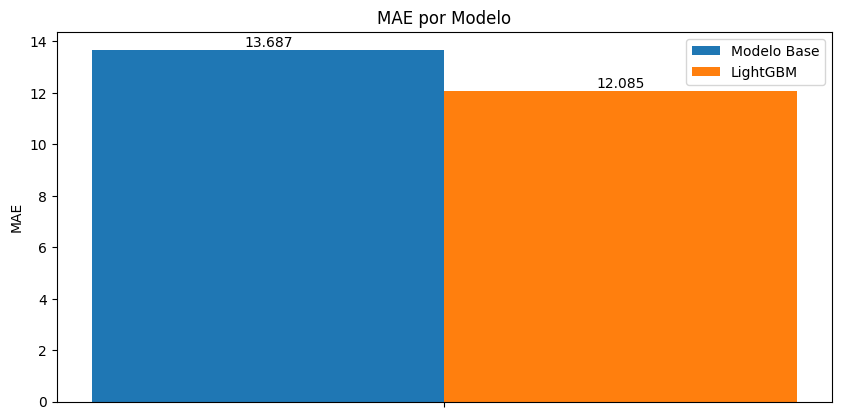

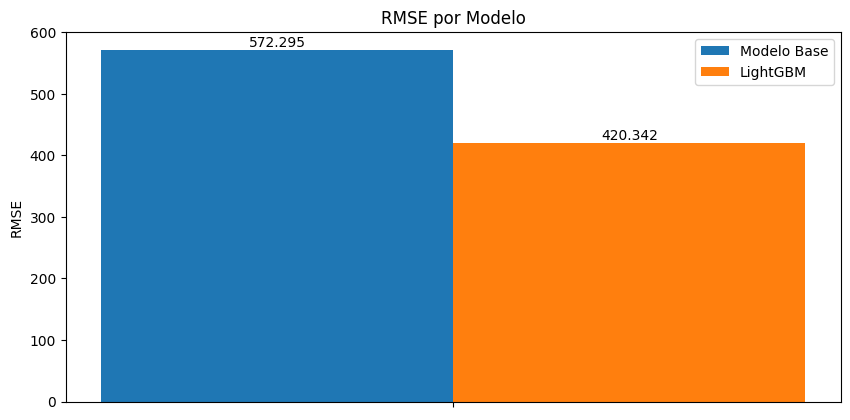

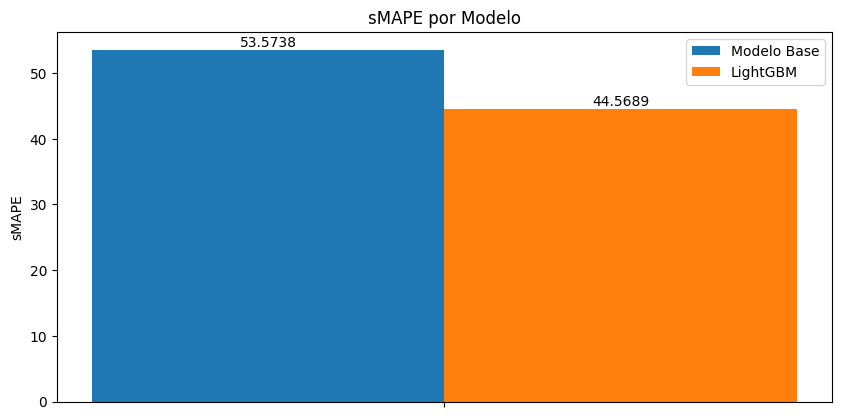

In [5]:
df_resultados = X_Test[["month", "CNES", "hospital_porte"]]
df_resultados["year"] = 2025
df_resultados = df_resultados[["year", "month", "CNES", "hospital_porte"]]
df_resultados["Valor Real"] = Y_Test
df_resultados["Base resultados"] = test_resul
for i in range(5):
    df_resultados["LightGBM resultados " + str(i)] = i_res[i]

def graf_resultado(titulo, metrica, valor_base, valor_lgb):
    fig = plt.figure()
    fig.set_figwidth(10)
    
    w, x = 0.4, np.arange(1)
    bars1 = plt.bar(x - w/2, [valor_base], w, label="Modelo Base")
    bars2 = plt.bar(x + w/2, [valor_lgb], w, label="LightGBM")
    plt.bar_label(bars1)
    plt.bar_label(bars2)
    plt.xticks(x, [""])
    plt.ylabel(metrica)
    plt.title(titulo)
    plt.legend()
    plt.show()

# MAE
base_mae = mean_absolute_error(y_true=Y_Test, y_pred=test_resul)
lgb_mae_ar = []
for i in range(5):
    lgb_mae_ar.append(mean_absolute_error(y_true=Y_Test, y_pred=i_res[i]))
lgb_mae = np.mean(lgb_mae_ar)

# RMSE
base_rmse = mean_squared_error(y_true=Y_Test, y_pred=test_resul)
lgb_rmse_ar = []
for i in range(5):
    lgb_rmse_ar.append(mean_squared_error(y_true=Y_Test, y_pred=i_res[i]))
lgb_rmse = np.mean(lgb_rmse_ar)

# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

base_smape = smape(y_true=Y_Test, y_pred=test_resul)
lgb_smape_ar = []
for i in range (5):
    lgb_smape_ar.append(smape(y_true=Y_Test, y_pred=i_res[i]))
lgb_smape = np.mean(lgb_smape_ar)

# Graficos
graf_resultado("MAE por Modelo", "MAE", base_mae, lgb_mae)
graf_resultado("RMSE por Modelo", "RMSE", base_rmse, lgb_rmse)
graf_resultado("sMAPE por Modelo", "sMAPE", base_smape, lgb_smape)